Total least squares(aka TLS) is one of regression analysis methods to minimize the sum of squared errors between a response variable(or, an observation) and a predicated value(we often say a fitted value). The most popular and standard method of this is Ordinary least squares(aka OLS). To get a practical understanding, we’ll compare OLS and Orthogonal distance regression(aka ODR), which is the regression model that aims to minimize an orthogonal distance.

# OLS: quick review
To brush up our knowledge, first let’s review regression analysis and OLS. In general, we use regression analysis to predict(or simulate) future events. To be more precise, if we have a bunch of data collected in the past(which is an independent variable) and also corresponding outcomes(which is a dependent variable), we can make the machine that predicts future outcomes with our new data that we just collected.

To make a better machine, we apply regression analysis and try to get better parameters, which is a slope and a constant for our models. For instance, let’s take a look at the figure below. We seek parameters of the red regression line(and blue points are data points (response variables and independent variables), and the length of grey line is the amount of the residual calculated by this estimator).

![ols-tls.png](images/ols-tls.png)

In OSL, the gray line isn’t orthogonal. This is the main and visually distinct difference between OSL and TLS(and ODR). The gray line is parallel to the y-axis in OSL, while it is orthogonal toward the regression line in TLS. The objective function (or loss function) of OLS is defined as:

![Eq1.png](images/Eq1.png)

Which is solved by a quadratic minimization. And we can get parameter vectors from that(this is all what we need).


![Eq2.png](images/Eq2.png)

Numpy provides numpy.linalg.lstsq for this though, it’s easy to implement this normal equation from scratch. We get parameter vectors in b in codes below and use it to predict fitted values. numpy.linalg.lstsq expects the constant c exists at a last index, so we need to switch the position of column values.

-0.02672390363575431 0.10785664775197898 -0.2493959726656507


Text(0, 0.5, 'y')

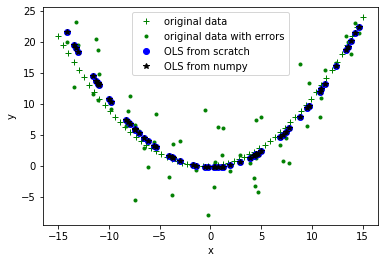

In [1]:
import numpy as np
from numpy.linalg import inv
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pylab as py 
from sklearn.metrics import mean_squared_error
%matplotlib inline 

N=60
mu=0
sd=2

np.random.seed(0)
ran = np.random.normal(size=N)
error1 = sd**2 * ran + mu
error2 = sd*.5 * ran + mu

lin = np.linspace(-15., 15., num=N)
data = lin + error2
data_true = lin


true_func = lambda x, e: .1*x + .1*x**2 + e
x = np.vstack((data, data**2)).T
y_true = np.array([true_func(d, 0) for d in data_true])
y_data = np.array([true_func(d, e) for d,e in zip(data, error1)])

#true function
plt.plot(data_true, y_true, marker='+', linestyle='None', color='g',label='original data')
#true function
plt.plot(data, y_data, marker='.', linestyle='None', color='g',label='original data with errors')


# from scratch
x = sm.add_constant(x) # add constant in the 0 index
b = inv(x.T.dot(x)).dot(x.T).dot(y_data)
yest_ols = np.array([b[2]*v**2 + b[1]*v + b[0] for v in x.T[1]])
plt.plot(x.T[1], yest_ols, marker='o', linestyle='None', color='b',label='OLS from scratch')

# with using numpy.linalg.lstsq
b1, b2, c = np.linalg.lstsq(sm.add_constant(x).T[[1,2,0]].T, y_data, rcond=None)[0]
print (b1,b2,c)

yest_ols = np.array([b2*v**2 + b1*v + c for v in data])
plt.plot(data, yest_ols, marker='*', linestyle='None', color='k',label='OLS from numpy')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')


# ODR: scratching the surface

There is the regression model that aims to minimize an orthogonal distance. Thankfully, Scipy provides scipy.odr package. We can set the error values wd and we in the Data function. This is for a weight matrix to address an unequal variance of residuals(heteroscedasticity). If we know how big/small the errors are beforehand, this tweak can improve the estimator. In the real world, however, it’s hard to determine or estimate that. This weighting is also the one of effective ways to improve the application of Weighted Least Squares and Generalized Least Squares.

We set 1× N array of error values in wd, which means ith error value is applied to ith data point.

[0.05010689 0.10311068]


Text(0, 0.5, 'y')

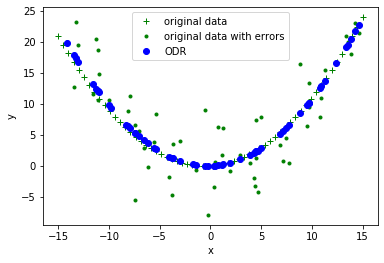

In [2]:
import scipy.odr as odr

def odr_line(B, x):
    y = B[0]*x + B[1]*x**2
    return y

def perform_odr(x, y, xerr, yerr):
    quadr = odr.Model(odr_line)
    mydata = odr.Data(x, y, wd=1./xerr, we=1./yerr)
    #mydata = odr.Data(x, y)
    myodr = odr.ODR(mydata, quadr, beta0=[0., 0.])
    output = myodr.run()
    return output

regression = perform_odr(data, y_data, np.abs(error2), np.abs(error1))

yest_odr = odr_line(regression.beta, data)
print (regression.beta)

#true function
plt.plot(data_true, y_true, marker='+', linestyle='None', color='g',label='original data')
#true function
plt.plot(data, y_data, marker='.', linestyle='None', color='g',label='original data with errors')

yest_odr = np.array([regression.beta[1]*v**2 + regression.beta[0]*v for v in x.T[1]])
plt.plot(x.T[1], yest_odr, marker='o', linestyle='None', color='b',label='ODR')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')


ODR fits better than others for this data set.

# Comparison of the methods
Let’s compare the methods and see their fitness visually. ODR fit very well on the center of the quadratic curve, however, as far away off the center they move, their prediction loss the precision. To interpret that, ODR work well when the variance of fitted values are small. 

Overall, ODR fits better in this data sample though, it depends on the data.

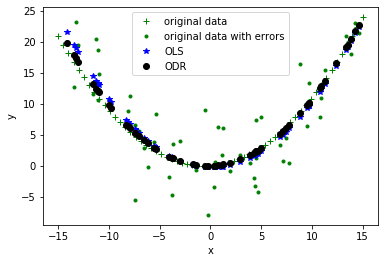

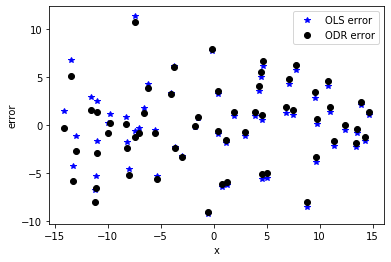

0.5265441042511964
0.5343746103119221


In [3]:
#true function
plt.plot(data_true, y_true, marker='+', linestyle='None', color='g',label='original data')
#true function
plt.plot(data, y_data, marker='.', linestyle='None', color='g',label='original data with errors')

plt.plot(x.T[1], yest_ols, marker='*', linestyle='None', color='b',label='OLS')
plt.plot(x.T[1], yest_odr, marker='o', linestyle='None', color='k',label='ODR')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')

error_OLS = yest_ols-y_data
error_ODR = yest_odr-y_data
plt.show()

plt.plot(x.T[1], error_OLS, marker='*', linestyle='None', color='b',label='OLS error')
plt.plot(x.T[1], error_ODR, marker='o', linestyle='None', color='k',label='ODR error')

plt.legend()
plt.xlabel('x')
plt.ylabel('error')
plt.show()
# Calculation of Mean Squared Error (MSE) 
RMS_OLS = error_OLS**2
RMS1=np.sqrt(np.sum(RMS_OLS))/len(RMS_OLS)
print (RMS1)
RMS_ODR = error_ODR**2
RMS2=np.sqrt(np.sum(RMS_ODR))/len(RMS_ODR)
print (RMS2)